In [1]:
import pandas as pd
import numpy as np
import random
from hmmlearn import hmm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

random.seed(4242)

#UPDATE PATH!
temporal = pd.read_csv("D:/OneDrive/Online/SelfLearn/Ryerson/MSc/PaperReplication/temporal_activity.csv", 
                       names = ["bugID", "timeStamp", "activity", "cumDays"])
activity = pd.read_csv("D:/OneDrive/Online/SelfLearn/Ryerson/MSc/PaperReplication/activity_description.csv", 
                      names = ["short", "description"])

# Identify short/fast days based on paper's definition
days = temporal.loc[:,['bugID', 'cumDays']].groupby(by='bugID').max()
days['isSlow'] = np.where(days.cumDays > 60, 1, 0)
# Provide a number for each activity
activity['code'] = activity.index 
temporal = pd.merge(temporal, activity, left_on='activity', right_on='short')
temporal = temporal.iloc[:,[0,1,2,3,6]]
temporal = temporal.sort_values(by=['bugID', 'timeStamp']).reset_index(drop=True)
# Insert isSlow flag
temporal = pd.merge(temporal, days.iloc[:,[1]], left_on='bugID', right_index=True)

temporal = temporal[temporal.activity != 'Z'] # Remove Zs - based on code
zeroChans = days[days.cumDays == 0].index.values # identify zero day bugs
openMask = temporal.activity.isin(['N', 'M', 'E']) # starting day - I have put this mask to match the results of Table 6

In [2]:
iterCount = 5
activities = 4
initCount = 40
numStates = 5
outputCount = len(np.unique(temporal.activity.values))
results = pd.DataFrame(columns=['Year', 'Precision', 'Recall', 'F-Score', 'Accuracy'])

# Initilize matrix once so that the change in results is not caused by the initilizations
np.random.seed(4242)
emissionprob = np.random.randint(low=1, high = 2000, size=(numStates,outputCount))
emissionprob = emissionprob/emissionprob.sum(axis=1, keepdims=True)

transmat = np.random.randint(low=1, high = 2000, size=(numStates,numStates))
transmat = transmat/transmat.sum(axis=1, keepdims=True)

startprob = np.random.randint(low=1, high = 2000, size=numStates)
startprob = startprob/startprob.sum(keepdims=True)

In [3]:
for i in range(5):
    year = 2007 + i
    print("Working on {0}".format(year))   
    for j in range(initCount):
        if j % 8 == 0:
            print("{0}th iteration".format(j))
        
        trainChans = temporal[(openMask) & (temporal.timeStamp >= (str(year-1))) & (temporal.timeStamp < (str(year))) & 
                              (~temporal.bugID.isin(zeroChans))].bugID.drop_duplicates().reset_index(drop=True)
        train = temporal[(temporal.timeStamp >= (str(year-1))) & (temporal.timeStamp < (str(year))) & 
                         (temporal.bugID.isin(trainChans))].reset_index(drop=True)

        # Shuffle by BugID 
        sorterIndex = dict(zip(train.bugID.sample(frac=1).values,range(len(train.bugID.values))))
        train['bugRank'] = train['bugID'].map(sorterIndex)
        train = train.sort_values(by=['bugRank', 'timeStamp']).reset_index(drop=True)
        train = train.drop('bugRank', axis=1)       
        
        testChans = temporal[(openMask) & (temporal.timeStamp >= (str(year))) & (temporal.timeStamp < (str(year+1))) & 
                             (~temporal.bugID.isin(zeroChans))].bugID.drop_duplicates().reset_index(drop=True)
        test = temporal[(temporal.timeStamp >= (str(year))) & (temporal.timeStamp < (str(year+1))) & 
                        (temporal.bugID.isin(testChans))].reset_index(drop=True)
        
        # Divide training set based on the flag
        X1 = train[train.isSlow == 1].code.values.reshape(-1,1)
        X2 = train[train.isSlow == 0].code.values.reshape(-1,1)
        lengths1 = train[train.isSlow == 1].groupby(['bugID']).count().code.tolist()
        lengths2 = train[train.isSlow == 0].groupby(['bugID']).count().code.tolist()

        slowModel = hmm.MultinomialHMM(n_components  = numStates, n_iter = iterCount)
        slowModel.startprob_ = startprob
        slowModel.transmat_ = transmat
        slowModel.emissionprob_ = emissionprob
        slowModel = slowModel.fit(X = X1, lengths = lengths1)
        
        fastModel = hmm.MultinomialHMM(n_components  = numStates, n_iter = iterCount)
        fastModel.startprob_ = startprob
        fastModel.transmat_ = transmat
        fastModel.emissionprob_ = emissionprob
        fastModel = fastModel.fit(X = X2, lengths = lengths2)
    
        prediction = test.copy()
        prediction.loc[:,'pred'] = pd.Series(np.repeat(-1, test.shape[0]), index=test.index)
        prediction = prediction.loc[:,['bugID','isSlow', 'pred']].drop_duplicates().reset_index(drop=True)

        # Classify bug based on the highest log lilelihood
        for i in range(testChans.shape[0]):
            temp = test[test.loc[:,'bugID'] == testChans.iloc[i]].code.values.reshape(-1,1)[0:activities]
            prediction.iloc[i,2] = np.where(slowModel.score(X = temp) > fastModel.score(X = temp), 1, 0)
        
        precision, recall, fscore, _  = precision_recall_fscore_support(y_true = prediction.isSlow.values,
                                                                y_pred = prediction.pred.values)
        accuracy = accuracy_score(y_true = prediction.isSlow.values,  y_pred = prediction.pred.values)

        temp = pd.DataFrame([[int(year), precision[1], recall[1], fscore[1], accuracy]], 
                 columns=['Year', 'Precision', 'Recall', 'F-Score', 'Accuracy'])
        results= results.append(temp)

Working on 2007
0th iteration
8th iteration
16th iteration
24th iteration
32th iteration
Working on 2008
0th iteration
8th iteration
16th iteration
24th iteration
32th iteration
Working on 2009
0th iteration
8th iteration
16th iteration
24th iteration
32th iteration
Working on 2010
0th iteration
8th iteration
16th iteration
24th iteration
32th iteration
Working on 2011
0th iteration
8th iteration
16th iteration
24th iteration
32th iteration


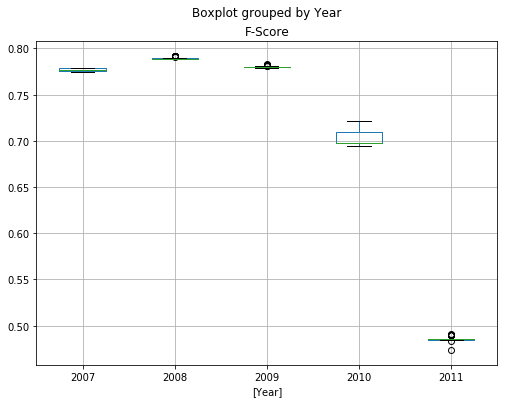

In [4]:
import matplotlib.pyplot as plt

results.loc[:,['Year', 'F-Score']].boxplot(by = 'Year', vert = True, figsize=(8,6))
plt.show()

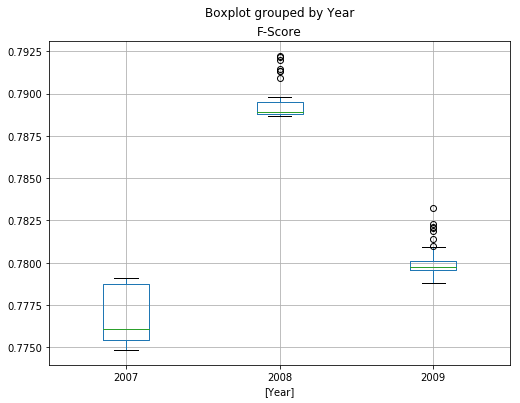

In [5]:
results2= results[results.Year.isin([2007,2008,2009])]

results2.loc[:,['Year', 'F-Score']].boxplot(by = 'Year', vert = True, figsize=(8,6))
plt.show()